# Koopman Operator Theory

The goal of this is to test how well we are able to learn representations of the Koopman operator for certain systems (note that by "learning a representation" I mean learning a matrix in a certain basis, such as polynomials or radial basis functions or Fourier functions or potentially something learned). Alternatively, we can hop into a RKHS with a chosen or learned kernel.

## References
Here are some references so that I don't need to keep tabs open all the time:
- **"Notes on Koopman Operator Theory"**, Brunton 
    - https://fluids.ac.uk/files/meetings/KoopmanNotes.1575558616.pdf
    - accompanies the textbook *Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control* by Brunton and Katz
    - very expository, no crazy math
    - good intro to DMD and eDMD, used below
    - has some good and very tangible examples
    - the methods discussed here are implemented in the `pykoopman` package (https://pykoopman.readthedocs.io), used below
- **"Learning Dynamical Systems via Koopman Operator Regression in Reproducing Kernel Hilbert Spaces"**, Italians 2022
     - https://arxiv.org/pdf/2205.14027.pdf
     - nice codebase at https://github.com/CSML-IIT-UCL/kooplearn (*⚠️@Evan⚠️: adapt this stuff to open systems*)
     - good background notes on Koopman theory under a certain Markov setting (assumes that there exists invariant measure)
     - awesome statistical learning math ab approximating the Koopman operator *and* its spectrum (spoiler: **low rank** methods like RRR approximate the spectrum better)
    - fairly operator-theoretic
    - "Designing a kernel function incorporating prior knowledge of the dynamical system (such as structure of the data points, symmetries, smoothness assumptions etc.) is a topic of paramount interest."
- **"Koopman Operator, Geometry, and Learning of Dynamical Systems"**, Mezic 2021
    - https://www.ams.org/journals/notices/202107/rnoti-p1087.pdf
    - much more general setting (open/control systems, continuous time)
    - focuses on **faithfulness** and **efficiency** of representations (with some fairly different math actually)
    - uses geometry to investigate stability
    - an Igor Mezic classic
    - **!!!!!!⚠️@EVAN⚠️ FINISH READING THIS!!!!!!!**
- **"Learning Compositional Koopman Operators for Model-Based Control"**, CSAIL 2020
    - https://arxiv.org/pdf/1910.08264.pdf
    - **!!!!!!⚠️@EVAN⚠️ PLEASE READ THIS!!!!!!!**
- the rest
    - https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/46449/Badrinath_washington_0250O_22221.pdf?sequence=1&isAllowed=y (someone's thesis about Koopman stuff)
    - dual faceted linearization (another linearization technique)
        - https://www.sciencedirect.com/science/article/pii/S2405896320322862?ref=pdf_download&fr=RR-2&rr=7d98d41e0bec0f91
        - https://dspace.mit.edu/bitstream/handle/1721.1/138456/2104.02004.pdf?sequence=2&isAllowed=y (somehow both Koopman and DFL methods)
        - https://dspace.mit.edu/bitstream/handle/1721.1/126131/ds_141_02_021002.pdf?sequence=2&isAllowed=y

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import tqdm

import numpy as np

import pykoopman as pk
from pykoopman.common import drss

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpo5owlvmt
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpo5owlvmt/_remote_module_non_scriptable.py


In [2]:
from typing import Tuple
from collections import deque

import jax.numpy as jnp

from extravaganza.lifters import Lifter
from extravaganza.sysid import SysID
from extravaganza.utils import set_seed, get_classname

class KoopmanLift(Lifter, SysID):
    def __init__(self,
                 hh: int,
                 control_dim: int,
                 state_dim: int,
                 obs_type: str = 'fourier',  # must be one of `['polynomial', 'radial', 'fourier']`
                 include_state: bool = True,
                 scale: float = 0.1,
                 buffer_maxlen: int = int(1e9),
                 seed: int = None):
        assert obs_type in ['polynomial', 'radial', 'fourier']
        
        set_seed(seed)
        super().__init__(hh, control_dim, state_dim, seed)
        
        self.hh = hh
        self.control_dim = control_dim
        self.state_dim = state_dim
        self.scale = scale
        
        self.buffer = deque(maxlen=buffer_maxlen)
        
        # to compute lifted states which hopefully respond linearly to the controls
        if obs_type == 'polynomial':
            obs = pk.observables.Polynomial(degree=3)
            raise NotImplementedError('oopsie, for some reason polynomial observations isnt working yet')
        elif obs_type == 'radial':
            obs = pk.observables.RadialBasisFunction(rbf_type='gauss', 
                                                     n_centers=self.state_dim-self.hh if include_state else self.state_dim, 
                                                     include_state=include_state)
        elif obs_type == 'fourier':
            D2 = self.state_dim - self.hh if include_state else self.state_dim
            assert D2 % 2 == 0, '{} should really be even'.format(D2)
            obs = pk.observables.RandomFourierFeatures(D=D2 // 2, include_state=include_state)

        self.lift_model = pk.Koopman(observables=obs, regressor=pk.regression.EDMDc())
        
        self.t = 1
        self.trained = False
        pass
    
    
    def map(self,
            cost_history: jnp.ndarray,
            control_history: jnp.ndarray) -> jnp.ndarray:
        """
        maps histories to lifted states. it's in pytorch rn, but that can change
        """
        assert cost_history.shape == (self.hh,)
        assert control_history.shape == (self.hh, self.control_dim)
        
        x = np.array(cost_history).reshape(1, self.hh)
        y = self.lift_model.observables.transform(x).squeeze(0)
        state = jnp.array(y)
        
        return state
    
    
    def perturb_control(self,
                        state: jnp.ndarray,
                        control: jnp.ndarray = None):
        assert state.shape == (self.state_dim,)
        eps = sample(jkey(), (self.control_dim,))  # random direction
        control = self.scale * eps
        self.t += 1
        return control
    
    def train(self):
        logging.info('({}): training!'.format(get_classname(self)))
            
        # get trajectory
        states = []
        controls = []
        for prev_histories, histories in self.buffer:
            states.append(np.array(prev_histories[0]))
            controls.append(np.array(histories[1][-1]))
        states, controls = map(lambda l: np.stack(l, axis=0), [states, controls])
        self.lift_model.fit(x=states, u=controls)
        
        self.A = jnp.array(self.lift_model.A.reshape(self.state_dim, self.state_dim))
        self.B = jnp.array(self.lift_model.B.reshape(self.state_dim, self.control_dim))
        self.trained = True
        pass
    
    def sysid(self):
        if not self.trained:
            self.train()
            A, B = jnp.array(self.A), jnp.array(self.B)
            logging.info('({}) ||A||_op = {}     ||B||_F {}'.format(get_classname(self), opnorm(A), jnp.linalg.norm(B, 'fro')))
            return A, B
        
        A, B = jnp.array(self.A), jnp.array(self.B)
        return A, B
    
    def update(self, 
               prev_histories: Tuple[jnp.ndarray, jnp.ndarray], 
               histories: Tuple[jnp.ndarray, jnp.ndarray]) -> float:
        self.buffer.append((prev_histories, histories))  # add the transition
        return 0.


In [8]:
from collections import defaultdict

from extravaganza.dynamical_systems import LDS, Gym
from extravaganza.lifters import LearnedLift, NoLift
from extravaganza.sysid import SysID
from extravaganza.utils import append

SEED = np.random.randint(5000)
ds, du = 1, 1   
hh = 6
lift_dim = 6
scale = 0.1
T0 = 4000
T = 4100

# make lifters
lifters = {
    'none': NoLift(hh, du),
    'radial': KoopmanLift(hh, du, lift_dim, 'radial', scale=scale, include_state=False),
    'fourier': KoopmanLift(hh, du, lift_dim, 'fourier', scale=scale, include_state=False),
    'learned': LearnedLift(hh, du, lift_dim, depth=4, scale=scale,
                          lift_lr = 0.01, sysid_lr=0.01, num_epochs=100)
}
sysid = SysID('moments', du, hh, scale)

# # make system
# disturbance_type = 'square wave'
# cost_fn = 'quad'
# system = LDS(ds, du, disturbance_type, cost_fn, seed=SEED)
system = Gym('CartPoleContinuous-v1', repeat=1, seed=SEED)

# training all the lifters
costs = []
cost_h, control_h = jnp.zeros(hh + 1), jnp.zeros((hh + 1, du))
control = sysid.perturb_control(cost_h[1:])  # use same controls for each lifter we are testing
for i in tqdm.trange(T0):
    cost, _ = system.interact(control)
    cost_h = append(cost_h, cost)
    costs.append(cost)
    control_h = append(control_h, control)
    
    if i > hh:
        prev_histories = (cost_h[:-1], control_h[:-1])
        histories = (cost_h[1:], control_h[1:])
        for k, l in lifters.items():
            l.update(prev_histories, histories)
    
    control = sysid.perturb_control(cost_h[1:])  # use same controls for each lifter we are testing
    
# testing all the lifters with a test trajectory
disturbances = defaultdict(list)

for i in tqdm.trange(T - T0):
    cost, _ = system.interact(control)
    cost_h = append(cost_h, cost)
    costs.append(cost)
    control_h = append(control_h, control)
    
    prev_histories = (cost_h[:-1], control_h[:-1])
    histories = (cost_h[1:], control_h[1:])
    
    for k, l in lifters.items():
        if k != 'none' and not l.trained: l.train()
        s = l if k != 'none' else sysid
        pred = s.dynamics(l.map(*prev_histories), control)
        disturbance = l.map(*histories) - pred
        disturbances[k].append(jnp.linalg.norm(disturbance))
    if 'ws' in system.stats._stats: disturbances['gt'].append(system.stats._stats['ws'].values[-1])
    
    control = sysid.perturb_control(cost_h[1:])  # use same controls for each lifter we are testing

/Users/evandigiorno/Desktop/extravaganza/env/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
  0%|                                                                                                                 | 0/100 [00:00<?, ?it/s]INFO: (KOOPMANLIFT): training!
/Users/evandigiorno/Desktop/extravaganza/env/lib/python3.10/site-packages/pykoopman/observables/_radial_basis_functions.py:161: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.measurement_matrix_ = np.linalg.lstsq(xlift, x)[0].T
INFO: (KOOPMANLIFT): training!
/Users/evandigiorno/Desktop/extravaganza/env/lib/python3.10/site-packages/pyk

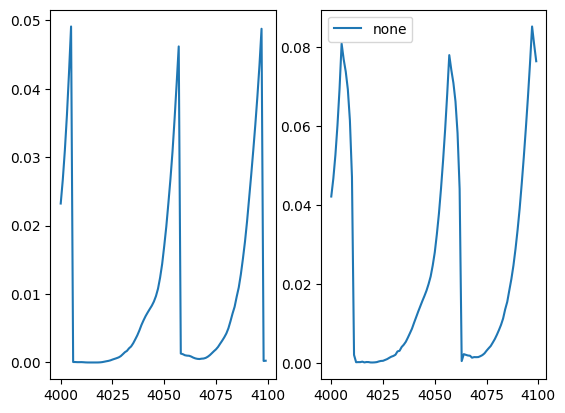

In [10]:
import matplotlib.pyplot as plt
from extravaganza.utils import window_average

fig, ax = plt.subplots(1, 2)

ax[0].plot(range(T0, T, 1), costs[T0:])

for k, d in disturbances.items():
    if k not in ['none']: continue
    ax[1].plot(range(T0, T, 1), d, label=k)
ax[1].legend()
plt.show()